In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from scipy.stats import spearmanr, kstest, norm

from bio_if.data.utils import FastaDataset, FixedIndexTokenizer
from bio_if.modules.mlp import MLPBlock

In [2]:
tokenizer_fn = FixedIndexTokenizer()

In [3]:
src = '../src/bio_if/data/FLIP/gb1/'
tasks = ['one_vs_rest', 'two_vs_rest', 'three_vs_rest', 'sampled']
datasets = {}
for task in tasks:
    datasets[task] = {}
    datasets[task]['train'] = FastaDataset(f'{src}/{task}.fasta', split='train', tokenizer_fn=tokenizer_fn)
    datasets[task]['val'] = FastaDataset(f'{src}/{task}.fasta', split='val', tokenizer_fn=tokenizer_fn)
    datasets[task]['test'] = FastaDataset(f'{src}/{task}.fasta', split='test', tokenizer_fn=tokenizer_fn)

In [4]:
# define an MLP
def init_regressor():
    D = 128
    return nn.Sequential(
        MLPBlock(80, D, use_relu=True),
        MLPBlock(D, D, use_relu=True),
        MLPBlock(D, 1, use_relu=False)
    )

In [5]:
dataloaders = {}
for task in tasks:
    dataloaders[task] = {
        'train': datasets[task]['train'].get_dataloader(batch_size=32, shuffle=True, drop_last=False),
        'val': datasets[task]['val'].get_dataloader(batch_size=32, shuffle=False, drop_last=False),
        'test': datasets[task]['test'].get_dataloader(batch_size=32, shuffle=False, drop_last=False)
    }
DEVICE = 'cuda:7'

In [6]:
def get_val_loss(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    return val_loss / len(dataloader)

In [7]:
def train_model(train_dataloader, val_dataloader, test_dataloader):
    EPOCHS = 10 # 00
    N_VAL_ATTEMPTS = 5
    LR = 1e-2

    loss_fn = nn.MSELoss()
    best_val_loss = float('inf')

    val_failures = 0
    model = init_regressor().to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.1, )

    losses = []
    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0
        for batch in tqdm(train_dataloader):
            input_ids, labels = batch
            input_ids, labels = input_ids.to(DEVICE), labels.to(DEVICE)
            outputs = model(input_ids).squeeze()
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        val_loss = get_val_loss(model, val_dataloader, loss_fn)
        print(f'Epoch {epoch} train loss: {train_loss / len(train_dataloader)}')
        print(f'Epoch {epoch} val loss: {val_loss}')
        losses.append((train_loss / len(train_dataloader), val_loss))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            val_failures = 0
            best_model = model.state_dict()
        else:
            val_failures += 1
            if val_failures >= N_VAL_ATTEMPTS:
                print(f'Early stopping at epoch {epoch}')
                break

    model.load_state_dict(best_model)
    # make a plot of the training and validation losses
    train_losses, val_losses = zip(*losses)
    test_loss = get_val_loss(model, test_dataloader, loss_fn)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.axhline(test_loss, color='r', linestyle='--', label='test')
    plt.legend()
    return model

100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


Epoch 0 train loss: 3.71879506111145
Epoch 0 val loss: 0.442729651927948


100%|██████████| 1/1 [00:00<00:00, 222.57it/s]


Epoch 1 train loss: 2.6847283840179443
Epoch 1 val loss: 0.12067845463752747


100%|██████████| 1/1 [00:00<00:00, 260.16it/s]


Epoch 2 train loss: 1.6708550453186035
Epoch 2 val loss: 0.3552306592464447


100%|██████████| 1/1 [00:00<00:00, 232.56it/s]


Epoch 3 train loss: 0.8613080978393555
Epoch 3 val loss: 1.754063606262207


100%|██████████| 1/1 [00:00<00:00, 228.04it/s]


Epoch 4 train loss: 1.3615782260894775
Epoch 4 val loss: 1.4090683460235596


100%|██████████| 1/1 [00:00<00:00, 223.84it/s]


Epoch 5 train loss: 1.0982202291488647
Epoch 5 val loss: 0.6567163467407227


100%|██████████| 1/1 [00:00<00:00, 221.09it/s]


Epoch 6 train loss: 0.5904844403266907
Epoch 6 val loss: 0.25186318159103394
Early stopping at epoch 6


/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


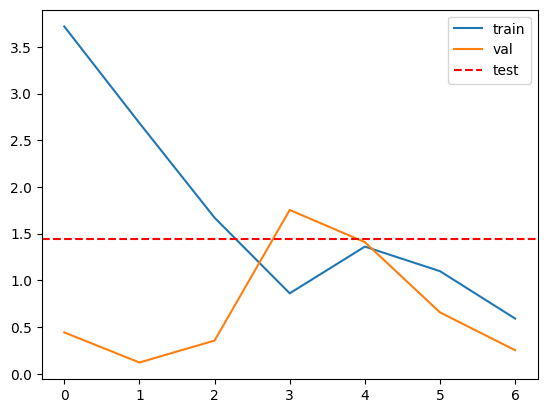

In [8]:
# train one vs rest
one_vs_rest_model = train_model(dataloaders['one_vs_rest']['train'], dataloaders['one_vs_rest']['val'], dataloaders['one_vs_rest']['test'])

100%|██████████| 12/12 [00:00<00:00, 255.89it/s]


Epoch 0 train loss: 1.1733723903695743
Epoch 0 val loss: 0.6532454192638397


100%|██████████| 12/12 [00:00<00:00, 234.36it/s]


Epoch 1 train loss: 0.4936331883072853
Epoch 1 val loss: 0.6554691791534424


100%|██████████| 12/12 [00:00<00:00, 240.61it/s]


Epoch 2 train loss: 0.25125814601778984
Epoch 2 val loss: 0.7631160914897919


100%|██████████| 12/12 [00:00<00:00, 244.77it/s]


Epoch 3 train loss: 0.1732498351484537
Epoch 3 val loss: 0.7930094003677368


100%|██████████| 12/12 [00:00<00:00, 250.09it/s]


Epoch 4 train loss: 0.12419040097544591
Epoch 4 val loss: 0.6697447896003723


100%|██████████| 12/12 [00:00<00:00, 251.58it/s]


Epoch 5 train loss: 0.08464150348057349
Epoch 5 val loss: 0.8032630085945129
Early stopping at epoch 5


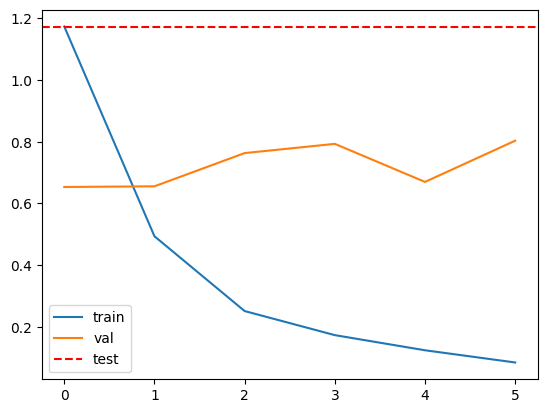

In [9]:
# train two vs rest
two_vs_rest_model = train_model(dataloaders['two_vs_rest']['train'], dataloaders['two_vs_rest']['val'], dataloaders['two_vs_rest']['test'])

100%|██████████| 85/85 [00:00<00:00, 254.34it/s]


Epoch 0 train loss: 0.7284270161653266
Epoch 0 val loss: 0.7676608383655548


100%|██████████| 85/85 [00:00<00:00, 250.23it/s]


Epoch 1 train loss: 0.36835379256483386
Epoch 1 val loss: 0.37819372192025186


100%|██████████| 85/85 [00:00<00:00, 258.79it/s]


Epoch 2 train loss: 0.2074243492063354
Epoch 2 val loss: 0.26908049136400225


100%|██████████| 85/85 [00:00<00:00, 216.09it/s]


Epoch 3 train loss: 0.17448384314775467
Epoch 3 val loss: 0.24453339874744415


100%|██████████| 85/85 [00:00<00:00, 256.29it/s]


Epoch 4 train loss: 0.1486362759681309
Epoch 4 val loss: 0.1853576757013798


100%|██████████| 85/85 [00:00<00:00, 259.24it/s]


Epoch 5 train loss: 0.12221669852185775
Epoch 5 val loss: 0.23040771037340163


100%|██████████| 85/85 [00:00<00:00, 257.65it/s]


Epoch 6 train loss: 0.10587038104148472
Epoch 6 val loss: 0.21193105578422547


100%|██████████| 85/85 [00:00<00:00, 253.61it/s]


Epoch 7 train loss: 0.09531047008931637
Epoch 7 val loss: 0.23014804981648923


100%|██████████| 85/85 [00:00<00:00, 257.95it/s]


Epoch 8 train loss: 0.10824359239024274
Epoch 8 val loss: 0.21147375777363778


100%|██████████| 85/85 [00:00<00:00, 256.83it/s]


Epoch 9 train loss: 0.11131657366366947
Epoch 9 val loss: 0.20696945190429689
Early stopping at epoch 9


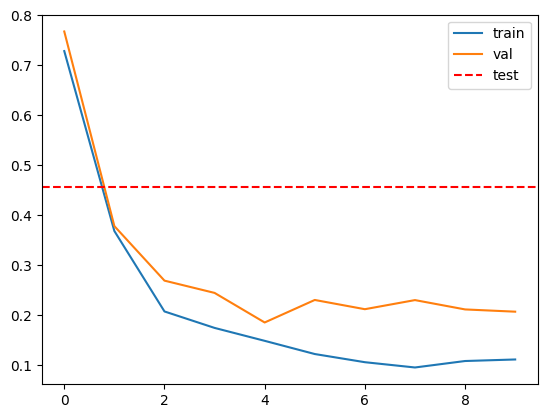

In [10]:
# train three vs rest
three_vs_rest_model = train_model(dataloaders['three_vs_rest']['train'], dataloaders['three_vs_rest']['val'], dataloaders['three_vs_rest']['test'])

100%|██████████| 197/197 [00:00<00:00, 248.26it/s]


Epoch 0 train loss: 0.5618119399030197
Epoch 0 val loss: 0.35583008571781893


100%|██████████| 197/197 [00:00<00:00, 265.15it/s]


Epoch 1 train loss: 0.2712276608962093
Epoch 1 val loss: 0.2408975020728328


100%|██████████| 197/197 [00:00<00:00, 263.66it/s]


Epoch 2 train loss: 0.20143153244241846
Epoch 2 val loss: 0.2143524776805531


100%|██████████| 197/197 [00:00<00:00, 268.07it/s]


Epoch 3 train loss: 0.16921780812483148
Epoch 3 val loss: 0.1941400243138725


100%|██████████| 197/197 [00:00<00:00, 266.46it/s]


Epoch 4 train loss: 0.15471732378157263
Epoch 4 val loss: 0.21656819703904065


100%|██████████| 197/197 [00:00<00:00, 262.13it/s]


Epoch 5 train loss: 0.15412060160019675
Epoch 5 val loss: 0.22562399980696765


100%|██████████| 197/197 [00:00<00:00, 266.54it/s]


Epoch 6 train loss: 0.1489012980937655
Epoch 6 val loss: 0.2371428884057836


100%|██████████| 197/197 [00:00<00:00, 266.44it/s]


Epoch 7 train loss: 0.13492971339125923
Epoch 7 val loss: 0.19082788174802606


100%|██████████| 197/197 [00:00<00:00, 254.41it/s]


Epoch 8 train loss: 0.14172108823121501
Epoch 8 val loss: 0.18428965700282293


100%|██████████| 197/197 [00:00<00:00, 202.24it/s]


Epoch 9 train loss: 0.13431095674180138
Epoch 9 val loss: 0.20500521395694127


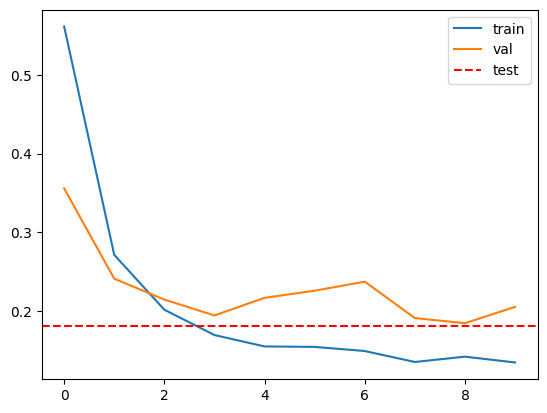

In [11]:
# train sampled
sampled_model = train_model(dataloaders['sampled']['train'], dataloaders['sampled']['val'], dataloaders['sampled']['test'])

In [10]:
def get_correlation(model, dataloader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids, label = batch
            input_ids, label = input_ids.to(DEVICE), label.to(DEVICE)
            outputs = model(input_ids).reshape(-1)
            preds.append(outputs)
            labels.append(label)
    preds = torch.cat(preds).numpy(force=True)
    labels = torch.cat(labels).numpy(force=True)
    return spearmanr(preds, labels), preds, labels

In [29]:
# get correlations and predictions for each model on all tasks and splits
correlations = {}
predictions = {}
labels = {}
for task in tasks:
    correlations[task] = {}
    predictions[task] = {}
    labels[task] = {}
    for split in ['train', 'val', 'test']:
        correlations[task][split], predictions[task][split], labels[task][split] = get_correlation(locals()[f'{task}_model'], dataloaders[task][split])


In [30]:
# print the correlations
for task in tasks:
    for split in ['train', 'val', 'test']:
        print(f'{task} {split} spearman correlation: {correlations[task][split][0]}')

one_vs_rest train spearman correlation: 0.8361538461538461
one_vs_rest val spearman correlation: 0.5
one_vs_rest test spearman correlation: 0.28287897671590323
two_vs_rest train spearman correlation: 0.9520048420103251
two_vs_rest val spearman correlation: 0.6418000604047116
two_vs_rest test spearman correlation: 0.6283980290157578
three_vs_rest train spearman correlation: 0.9452436691797084
three_vs_rest val spearman correlation: 0.8882405406128075
three_vs_rest test spearman correlation: 0.8701991968747315
sampled train spearman correlation: 0.9452878526562679
sampled val spearman correlation: 0.9254606074716829
sampled test spearman correlation: 0.9243624777068263


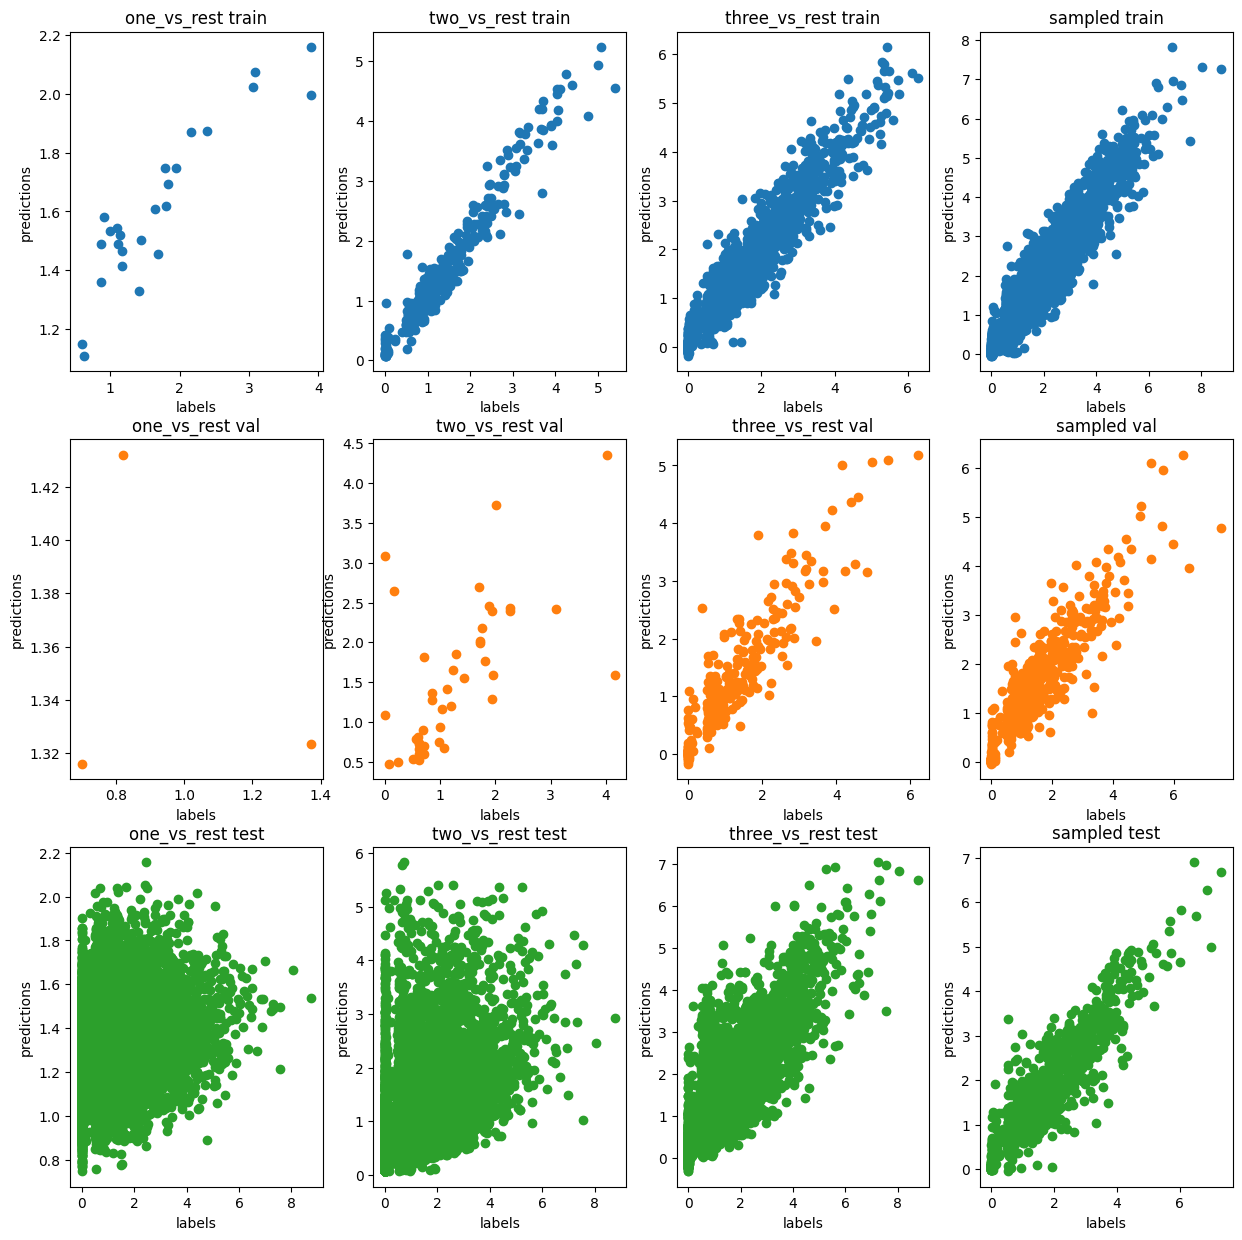

In [31]:
# make a grid of 3 rows and 4 columns with the following plots:
# each row is a split
# each column is a task
# each plot is a scatter plot of the predictions vs the labels
color = {
    'train': 'C0',
    'val': 'C1',
    'test': 'C2'
}
fig, axs = plt.subplots(3, 4, figsize=(15, 15))
for i, task in enumerate(tasks):
    for j, split in enumerate(['train', 'val', 'test']):
        
        axs[j, i].scatter(labels[task][split], predictions[task][split], color=color[split])
        axs[j, i].set_title(f'{task} {split}')
        axs[j, i].set_xlabel('labels')
        axs[j, i].set_ylabel('predictions')



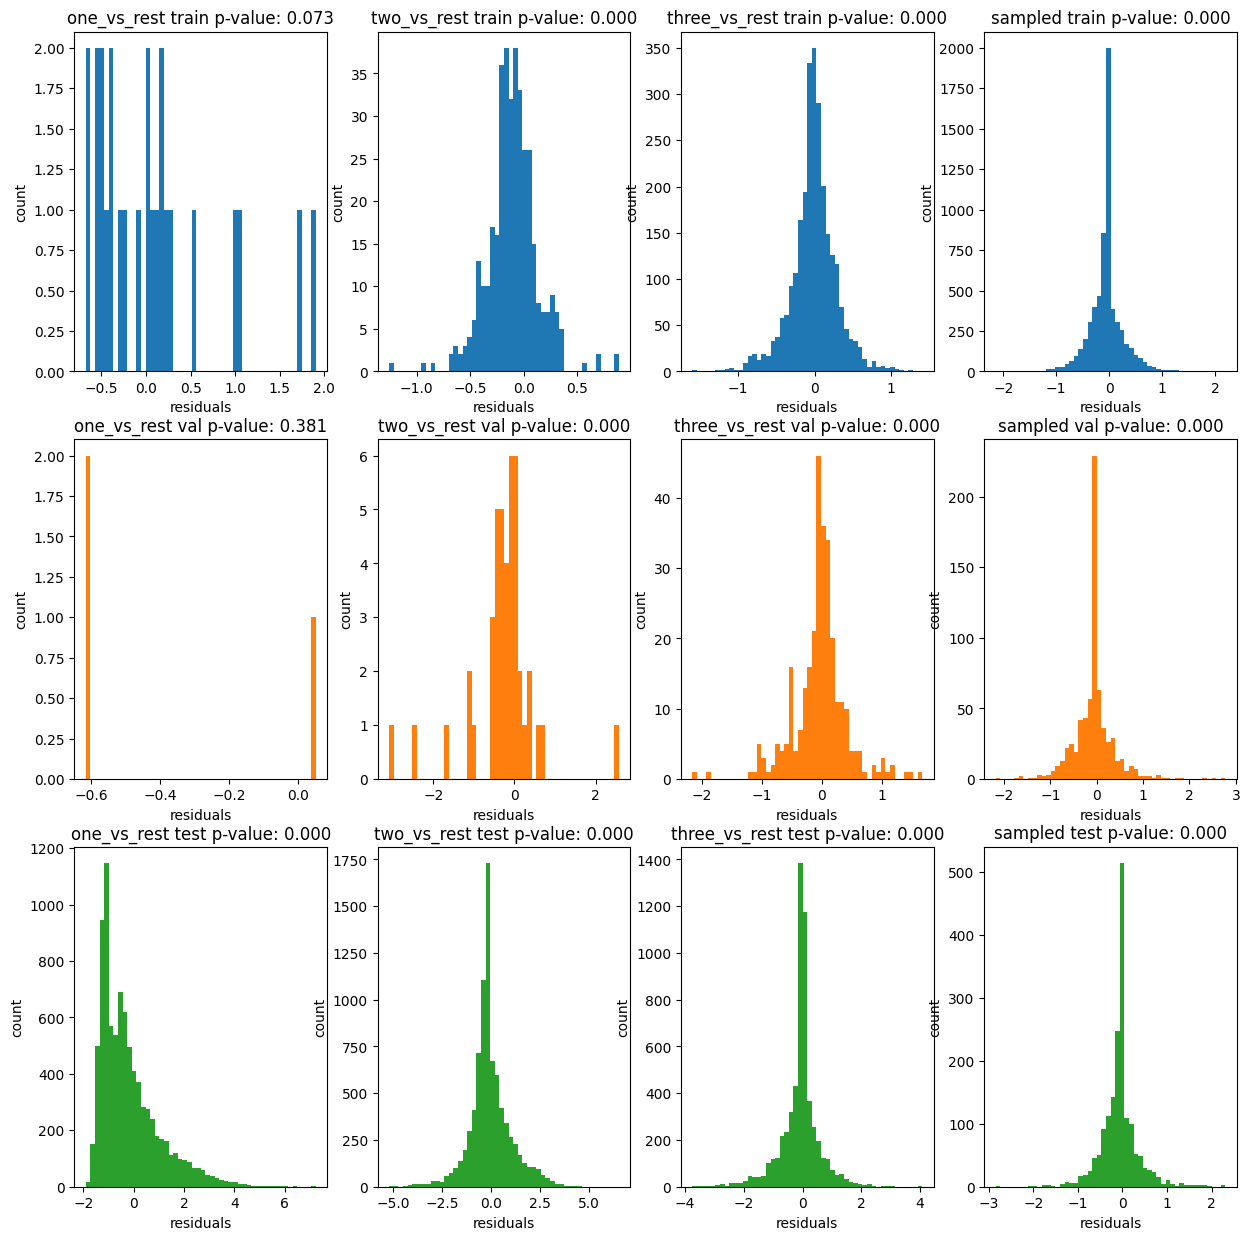

In [37]:
# make a histogram of the residuals for each model and split
fig, axs = plt.subplots(3, 4, figsize=(15, 15))
for i, task in enumerate(tasks):
    for j, split in enumerate(['train', 'val', 'test']):
        residuals = labels[task][split] - predictions[task][split]
        # axs[j, i].hist(residuals, bins=50, color=color[split])
        # axs[j, i].set_title(f'{task} {split}')
        # axs[j, i].set_xlabel('residuals')
        # axs[j, i].set_ylabel('count')
        # # compute the Kolmogorov-Smirnov test
        # _, p = kstest(residuals, norm.cdf)
        # axs[j, i].set_title(f'{task} {split} p-value: {p:.3f}')
        # make a qq plot
        

In [16]:
# compute influence function of the model
from bio_if.modules.influence import influence

In [17]:
def get_test_influence(train_dataset, test_dataset, model):
    # turn train dataset into a list
    train_list = list(train_dataset)
    test_list = list(test_dataset)

    # "tokenize" the first value of each tuple
    train_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in train_list]
    test_list = [(tokenizer_fn(x).reshape(1, -1), y) for x, y in test_list]

    influences = influence(
        model,
        list(model),
        test_list,
        train_list,
        train_list,
        DEVICE,
        torch.nn.functional.mse_loss, aggregate_query_grads=True
    )
    return influences

In [18]:
influences = {}
for task in tasks:
    print(f'Computing influence for {task}')
    influences[task] = get_test_influence(datasets[task]['train'], datasets[task]['test'], locals()[f'{task}_model'])

Computing influence for one_vs_rest


Computing EKFAC factors and pseudo gradients


  0%|          | 0/25 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:61: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 25/25 [00:00<00:00, 212.87it/s]


Computing search gradients


  0%|          | 0/25 [00:00<?, ?it/s]/home/cadegord/projects/bio-if/src/bio_if/modules/influence.py:96: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = loss_fn(output, target)
100%|██████████| 25/25 [00:00<00:00, 358.06it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 209.32it/s]


Computing influence for two_vs_rest
Computing EKFAC factors and pseudo gradients


100%|██████████| 381/381 [00:01<00:00, 199.33it/s]


Computing search gradients


100%|██████████| 381/381 [00:01<00:00, 233.13it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 220.79it/s]


Computing influence for three_vs_rest
Computing EKFAC factors and pseudo gradients


100%|██████████| 2691/2691 [00:13<00:00, 206.17it/s]


Computing search gradients


100%|██████████| 2691/2691 [00:11<00:00, 231.08it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 212.41it/s]


Computing influence for sampled
Computing EKFAC factors and pseudo gradients


100%|██████████| 6289/6289 [00:30<00:00, 204.84it/s]


Computing search gradients


100%|██████████| 6289/6289 [00:27<00:00, 227.28it/s]


Computing iHVP


100%|██████████| 1/1 [00:00<00:00, 200.24it/s]


In [20]:
# save all models and influences to a folder stamped with the date and time
import os
from datetime import datetime
now = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
os.makedirs(f'cached_runs/gb1/{now}', exist_ok=True)
# save the models state dicts and influences
torch.save(one_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/one_vs_rest_model.pt')
torch.save(two_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/two_vs_rest_model.pt')
torch.save(three_vs_rest_model.state_dict(), f'cached_runs/gb1/{now}/three_vs_rest_model.pt')
torch.save(sampled_model.state_dict(), f'cached_runs/gb1/{now}/sampled_model.pt')
torch.save(influences, f'cached_runs/gb1/{now}/influences.pt')

In [8]:
# load the influences
version = "2024-03-11_19-59-26"
influences = torch.load(f'cached_runs/gb1/{version}/influences.pt')

In [26]:
# load the models
one_vs_rest_model = init_regressor()
one_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/one_vs_rest_model.pt'))
two_vs_rest_model = init_regressor()
two_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/two_vs_rest_model.pt'))
three_vs_rest_model = init_regressor()
three_vs_rest_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/three_vs_rest_model.pt'))
sampled_model = init_regressor()
sampled_model.load_state_dict(torch.load(f'cached_runs/gb1/{version}/sampled_model.pt'))
one_vs_rest_model.to(DEVICE)
two_vs_rest_model.to(DEVICE)
three_vs_rest_model.to(DEVICE)
sampled_model.to(DEVICE)

Sequential(
  (0): MLPBlock(
    (linear): Linear(in_features=80, out_features=128, bias=True)
    (relu): ReLU()
  )
  (1): MLPBlock(
    (linear): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
  )
  (2): MLPBlock(
    (linear): Linear(in_features=128, out_features=1, bias=True)
    (relu): ReLU()
  )
)

In [22]:
influences

{'one_vs_rest': tensor([-0.0731, -0.0077,  0.0302, -0.0322,  0.1029,  0.0232,  0.0099, -0.0607,
         -0.0559, -0.0586,  0.1876, -0.0782,  0.1875,  0.0069, -0.0535, -0.0866,
         -0.0678,  0.0270, -0.0480,  0.0058,  0.0468, -0.0377,  0.0325,  0.3387,
          0.3200], device='cuda:7'),
 'two_vs_rest': tensor([-4.2621e-03,  1.1310e-02,  1.3762e-02,  1.0573e-02,  1.8806e-02,
          1.4829e-02,  4.3149e-03,  1.0940e-02, -7.3659e-04, -9.8859e-03,
         -9.9942e-05,  3.9892e-03,  5.1693e-03, -1.0108e-02,  4.5969e-03,
         -1.5206e-02,  1.4655e-02, -1.3090e-02,  5.3820e-03,  3.9410e-03,
          4.7858e-03, -9.7180e-03, -7.7959e-03,  4.6231e-03,  1.5382e-02,
         -7.7242e-04, -4.8879e-03, -1.8703e-03, -1.7123e-03, -6.5328e-03,
         -7.9605e-03, -1.7172e-03, -5.3539e-03,  2.5457e-03,  4.2783e-03,
         -2.9545e-02, -3.3806e-02, -6.8762e-03, -4.1228e-03, -3.8301e-03,
         -7.4825e-03, -1.1626e-02, -8.4037e-03, -4.8697e-02, -1.4204e-02,
         -1.0275e-03,  2

In [38]:
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

In [24]:
def compute_alpha(influences):
    # sort influences and take top 1 percent
    influences_sorted = torch.sort(influences).values.numpy(force=True)
    n = len(influences_sorted)
    top_1_percent = influences_sorted[int(n * 0.99):]
    n_top_1 = len(top_1_percent)
    # cdf: y = 1 - (x / x_min) ** -alpha
    # 1-y = (x / x_min) ** -alpha
    # log(1-y) = -alpha * log(x / x_min)
    # fit a power law to the top 1 percent
    # fit ridge regression to the above equation
    log_y = np.log(1-np.linspace(0.99, 1, n_top_1, endpoint=False))
    log_y_mean = log_y.mean()
    log_x = np.log(top_1_percent) - np.log(top_1_percent.min())
    log_x_mean = log_x.mean()
    alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
    return alpha

In [47]:
def plot_comp_cdf(influences, ax):
    influences_sorted = torch.sort(influences).values.numpy(force=True)
    n = len(influences)
    top_1_percent = influences_sorted[int(n * 0.99):]
    alpha = compute_alpha(influences)
    complementary_cdf = 1-np.linspace(0, 1, n, endpoint=False)
    # plot a power law to the top 1 percent
    m = top_1_percent[0]
    v = np.exp(np.log(0.01)-alpha * (np.log(top_1_percent[-1]/m) - np.log(top_1_percent[0]/m)))
    if not np.isnan(alpha):
        ax.plot((top_1_percent[0], top_1_percent[-1]), (0.01, v), label=f'α={alpha:.2f}', linestyle='--', linewidth=3, zorder=10)
    # sns.lineplot([top_1_percent[0], top_1_percent[-1]], [0.01, 0], label='Power Law Fit')

    # plot a CDF of the influences
    ax.plot(influences_sorted, complementary_cdf, linewidth=3, color='C1')
    ax.set_xlabel('Influence')
    ax.set_ylabel('1-CDF')
    # make the plot log-log
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e-3, 1)
    ax.legend()

/tmp/ipykernel_2124312/4018897033.py:16: RuntimeWarning: invalid value encountered in scalar divide
  alpha = -np.sum((log_x - log_x_mean) * (log_y - log_y_mean)) / np.sum((log_x - log_x_mean) ** 2)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


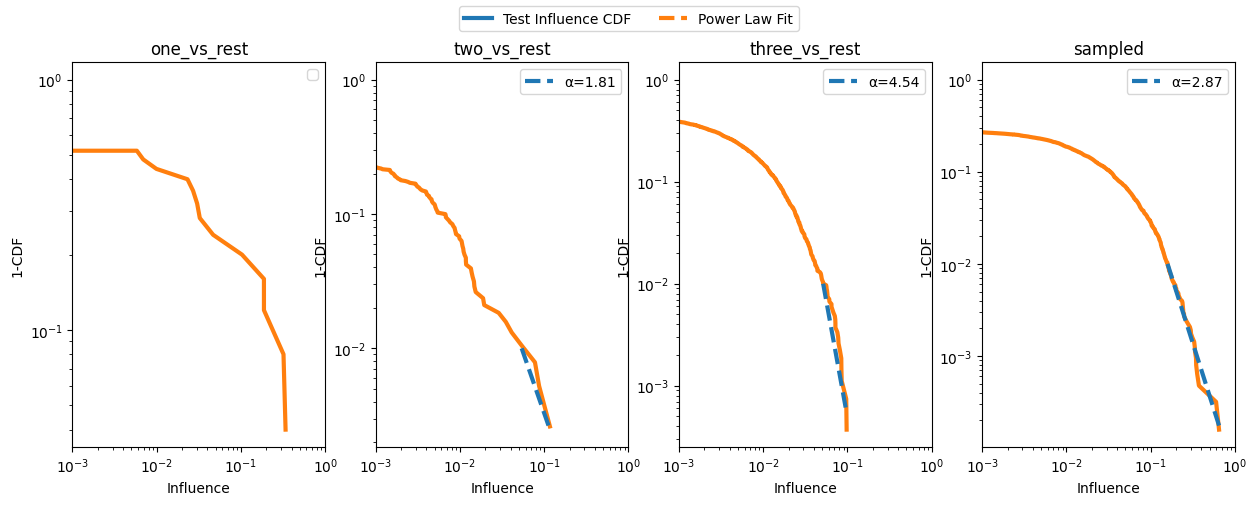

In [48]:
# plot the complementary CDF of the influences in a log-log plot for each of the tasks
fig, axs = plt.subplots(1, 4, figsize=(15, 5))
for i, task in enumerate(tasks):
    plot_comp_cdf(influences[task], axs[i])
    axs[i].set_title(task)
# add a legend to the whole plot
custom_lines = [Line2D([0], [0], color='C0', lw=3),
                Line2D([0], [0], color='C1', lw=3, linestyle='--')]
fig.legend(custom_lines, ['Test Influence CDF', 'Power Law Fit'], loc='upper center', ncol=2)